In [1]:
from pyiceberg.catalog import load_catalog
from pyiceberg.schema import Schema
import pyarrow as pa
from decimal import Decimal
from iceberg_table_schema import SCHEMAS
from celery import shared_task
from datetime import datetime
from sqlalchemy import create_engine, text
from sqlalchemy.pool import QueuePool
from database import update_metadata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

MySQL Version: 8.0.42
Connection pool created successfully


In [9]:
catalog = load_catalog(
    "default",  # Default catalog name
)
namespaces = catalog.list_namespaces()
print("Namespaces:", namespaces)
table_name = "Drivers"
iceberg_table = catalog.load_table(f"sales.Drivers")
df = iceberg_table.scan(
    row_filter="status == 'Incomplete' and app_date >= '04/01/2025'",
    limit=40,
    selected_fields=("app_no", "type", "status", "app_date"),
).to_pandas()

Namespaces: [('sales',)]


In [10]:
df["app_date"] = pd.to_datetime(df["app_date"])

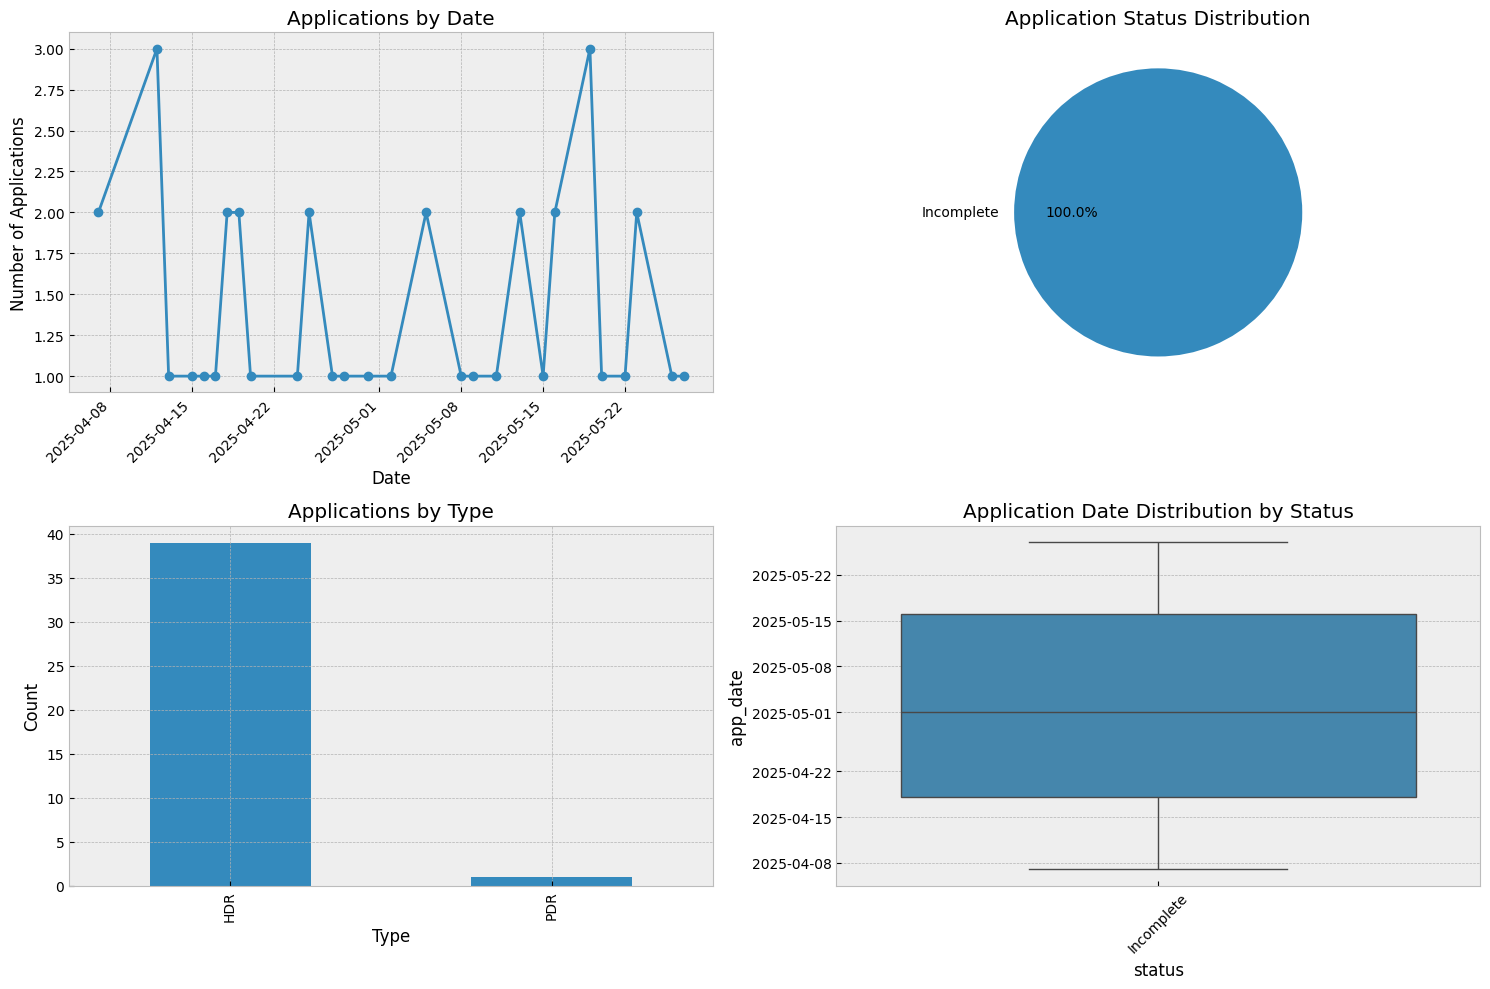

In [12]:
# Set the style to a built-in matplotlib style
plt.style.use("bmh")  # Using 'bmh' style instead of 'seaborn'

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))

# 1. Applications over time
plt.subplot(2, 2, 1)
df["app_date"].value_counts().sort_index().plot(kind="line", marker="o")
plt.title("Applications by Date")
plt.xlabel("Date")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45)

# 2. Status distribution
plt.subplot(2, 2, 2)
status_counts = df["status"].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct="%1.1f%%")
plt.title("Application Status Distribution")

# 3. Applications by type
plt.subplot(2, 2, 3)
df["type"].value_counts().plot(kind="bar")
plt.title("Applications by Type")
plt.xlabel("Type")
plt.ylabel("Count")

# 4. Box plot of applications by status
plt.subplot(2, 2, 4)
sns.boxplot(x="status", y="app_date", data=df)
plt.title("Application Date Distribution by Status")
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
